# MHC Binding Prediction

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd

import sys, os, math, re

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import f1_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import xgboost as xgb

import time
from IPython.display import display

import csv

%matplotlib inline

feature generation
every 2 AA to generate 400 features, total 8x400 features


In [2]:
def BuildBlosum62():
    df = pd.read_csv('blosum62.csv')
    return df

def GetSimilarMatrix(df, aa0, aa1):
    assert aa0 in df.index, "non-exist row {}".format(aa0)
    assert aa1 in df.columns.tolist(), "non-exist column {}".format(aa1)
    return df.loc[aa0, aa1]

aminolist = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

def run_xgb_cv(p, k, X, y):
    xgb_dp = xgb.DMatrix(data=X,label=y)
    xgb_cv = cv(dtrain=xgb_dp, params=p, nfold=k, num_boost_round=300, metrics="auc", as_pandas=True, seed=123)
    return xgb_cv
    
def BuildFeature(df, seq, segment=2, type='sparse'):
    row = {}
    if segment == 2:
        #for i in range(len(seq)-1):
        for i in range(9-segment+1):
            for r in aminolist:
                for c in aminolist:
                    score1 = GetSimilarMatrix(df, seq[i:i+1], r)
                    score2 = GetSimilarMatrix(df, seq[i+1:i+2], c)
                    if type == 'sparse':
                        row[str(i)+'_'+r+c] = score1 + score2
                        #print(str(i)+'_'+r+c+' '+str(score1)+' '+str(score2))
                    else:
                        if r+c in row.keys():
                            row[r+c] = row[r+c] + score1 + score2
                        else:
                            row[r+c] = score1 + score2
    elif segment == 3:
        for i in range(9-segment+1):
            for d0 in aminolist:
                for d1 in aminolist:
                    for d2 in aminolist:
                        score1 = GetSimilarMatrix(df, seq[i:i+1], d0)
                        score2 = GetSimilarMatrix(df, seq[i+1:i+2], d1)
                        score3 = GetSimilarMatrix(df, seq[i+2:i+3], d2)
                        if type == 'sparse':
                            row[str(i)+'_'+d0+d1+d2] = score1 + score2 + score3
                            #print(str(i)+'_'+r+c+' '+str(score1)+' '+str(score2))
                        else:
                            if d0+d1+d2 in row.keys():
                                row[d0+d1+d2] = row[d0+d1+d2] + score1 + score2 + score3
                            else:
                                row[d0+d1+d2] = score1 + score2 + score3

    return row

In [3]:
def show_roc_curve(y_test, y_pred):
    auc_roc = roc_auc_score(y_test, y_pred)
    print("AUC-ROC:", auc_roc)
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def LoadDataset(pos_file, neg_file):
    features = []
    classes = []

    with open(os.path.join('dataset', pos_file), 'r', encoding='utf-8') as pep_input:
        for line in pep_input:
            if re.match(line, '^#'):
                continue 
            line = line.strip()
            if line.isalpha():
                seq=str(line).upper()
                features.append(seq)
                classes.append(1)

    with open(os.path.join('dataset', neg_file), 'r', encoding='utf-8') as pep_input:
        for line in pep_input:
            if re.match(line, '^#'):
                continue
            line = line.strip()
            if line.isalpha():
                seq=str(line).upper()
                features.append(seq)
                classes.append(0)

    dataset = pd.DataFrame(
        {
            'sequence': features,
            'class': classes
        }
    )

    print(dataset)

    labels = ["Binded",'Not binded']
    values = dataset['class'].value_counts()[[1,0]].values
    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels,  autopct='%1.1f%%')
    plt.show()

    return dataset

       sequence  class
0     AIIDYIAYM      1
1     AIYDTMQYV      1
2     ALATFTVNI      1
3     ALDEGLLPV      1
4     ALFPIIWAL      1
...         ...    ...
9046  KEGAFFLYD      0
9047  KTLCDMIKG      0
9048  RRTRREAIV      0
9049  MMVIFRLMR      0
9050  GKRSNTTGK      0

[9051 rows x 2 columns]


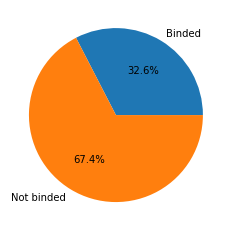

      sequence  class
0    STAFDFLAV      1
1    SQSPSSFSM      1
2    FALGNVISA      1
3    KINLSLFAL      1
4    LLDSLPMDV      1
..         ...    ...
295  YLYDRLLRI      0
296  YLSKIIPAL      0
297  TPTVPSGSF      0
298  VVLSWAPPV      0
299  ARDIYRASY      0

[300 rows x 2 columns]


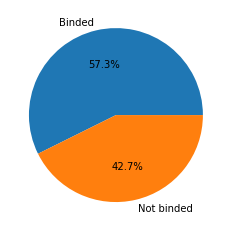

        sequence  class
0      KMVELVHFL      1
1      MIKNLTQLF      1
2      TQDLVQEKY      1
3      LRFPGQLNA      1
4      KVYDKLFPV      1
...          ...    ...
17341  TLNAWVKVV      0
17342  TLRKERLAK      0
17343  FYLYLTFYF      0
17344  FYPINDDFY      0
17345  KLDDVEKEK      0

[17346 rows x 2 columns]


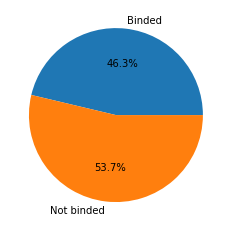

       sequence  class
0     LTMDREMLY      1
1     GMVTLYLGV      1
2     IMSLFSTSA      1
3     SASRAWNVW      1
4     ILIEGVFFA      1
...         ...    ...
2804  IVNNQESNK      0
2805  NEEVAIILA      0
2806  STYGISEDL      0
2807  HAPWTQMAM      0
2808  LSDAARLFL      0

[2809 rows x 2 columns]


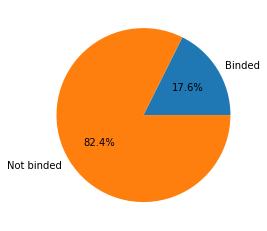

        sequence  class
0      KLRPRWLDA      1
1      RSLKAFFSW      1
2      WIMKIGIGV      1
3      FLAIKLYGV      1
4      NHIEVELSL      1
...          ...    ...
15346  YMMDGNECP      0
15347  NLPSKPVWL      0
15348  LSPAHLINK      0
15349  EHGRTTGLC      0
15350  NPAWRKAVF      0

[15351 rows x 2 columns]


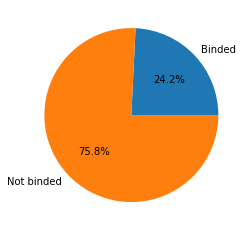

        sequence  class
0      GLAATSFPL      1
1      FTLIDIWFL      1
2      FTDPSSIAA      1
3      LLPEQLLKI      1
4      KIRPTRSVY      1
...          ...    ...
61399  IPSSSPTTA      0
61400  SLACSWGMV      0
61401  HPLARTAKV      0
61402  KSDEESNNQ      0
61403  CHEEIANHP      0

[61404 rows x 2 columns]


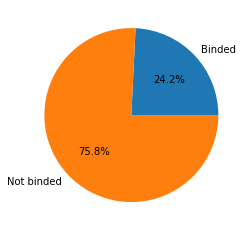

      sequence  class
0    GMHLLITGL      1
1    NLSGNTALL      1
2    KLMNIQQKL      1
3    KLKLPIIMK      1
4    VLAVSVLAA      1
..         ...    ...
141  PLEGTSFIV      0
142  EEEYPGITA      0
143  YSDNSNGSF      0
144  EERVINEEY      0
145  EEENFYLEP      0

[146 rows x 2 columns]


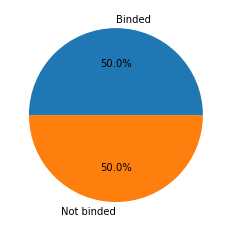

In [4]:
dataset1 = LoadDataset(pos_file='Positive_A0201_9AA_binder_pep.txt', neg_file='Negative_A0201_9AA_nonbinder_pep.txt')
dataset_cancer = LoadDataset(pos_file='dbPepNeo_HC_neoantigens_positive.txt', neg_file='dbPepNeo_HC_neoantigens_negative.txt')
dataset_fxxx = LoadDataset(pos_file='f123_ba_positive.txt', neg_file='f000_ba_negative.txt')
dataset_cxxx = LoadDataset(pos_file='c000_ba_test_positive.txt', neg_file='c000_ba_test_negative.txt')

dataset_c0001234 = LoadDataset(pos_file='c0001234_all_ba_positive.txt', neg_file='c0001234_all_ba_negative.txt')
dataset_f0001234 = LoadDataset(pos_file='f0001234_all_ba_positive.txt', neg_file='f0001234_all_ba_negative.txt')
dataset_mc_cancer = LoadDataset(pos_file='MC_cancer_neoantigns_positive.txt', neg_file='MC_cancer_neoantigns_negative.txt')
#dataset_necid = LoadDataset(pos_file='NECID_Query_all_positive_9aa.txt', neg_file='NECID_Query_all_negative_mut.txt')


Experiment: generate 8x400 feature table

In [5]:
scoreTable = BuildBlosum62()
print(scoreTable)

X_list = {}
y_list = {}

ds_list = {
    #'ds_fxxx': dataset_fxxx,
    #'ds_cxxx': dataset_cxxx,
    #'ds_cancer': dataset_cancer,
    'ds_c0001234': dataset_c0001234,
    #'ds_f0001234': dataset_f0001234,
    'ds_mc_cancer': dataset_mc_cancer
}

LOAD_EXISTING_DATA = False
if LOAD_EXISTING_DATA:
    for key in ds_list:
        store = pd.HDFStore(key+'.h5')
        X_ = store['X']
        y_ = store['y']
        store.close()
        X_list[key] = X_
        y_list[key] = y_
else:
    for key, value in ds_list.items():
        X_ = []
        y_ = []
        start = time.time()
        ds = value
        for index in range(len(ds)):
            #feat = BuildFeature(df=scoreTable, seq=ds.loc[index, 'sequence'], type='sparse')
            feat = BuildFeature(df=scoreTable, seq=ds.loc[index, 'sequence'], segment=3, type='condense')
            X_.append(feat)
            y_.append(ds.loc[index, 'class'])

        X_ = pd.DataFrame(X_)
        y_ = pd.DataFrame(y_)
        print(X_)

        store = pd.HDFStore(key+'.h5')
        store['X'] = X_
        store['y'] = y_
        store.close()

        X_list[key] = X_
        y_list[key] = y_
        end = time.time()
        print("Time to build feature vector: {} sec".format(end-start))

use_train = 'ds_c0001234'
X = X_list[use_train]
y = y_list[use_train]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)
print(X_train)
print(y_train)

   A  R  N  D  C  Q  E  G  H  I  ...  K  M  F  P  S  T   W  Y  V  X
A  4 -1 -2 -2  0 -1 -1  0 -2 -1  ... -1 -1 -2 -1  1  0  -3 -2  0  0
R -1  5  0 -2 -3  1  0 -2  0 -3  ...  2 -1 -3 -2 -1 -1  -3 -2 -3 -1
N -2  0  6  1 -3  0  0  0  1 -3  ...  0 -2 -3 -2  1  0  -4 -2 -3 -1
D -2 -2  1  6 -3  0  2 -1 -1 -3  ... -1 -3 -3 -1  0 -1  -4 -3 -3 -1
C  0 -3 -3 -3  9 -3 -4 -3 -3 -1  ... -3 -1 -2 -3 -1 -1  -2 -2 -1 -2
Q -1  1  0  0 -3  5  2 -2  0 -3  ...  1  0 -3 -1  0 -1  -2 -1 -2 -1
E -1  0  0  2 -4  2  5 -2  0 -3  ...  1 -2 -3 -1  0 -1  -3 -2 -2 -1
G  0 -2  0 -1 -3 -2 -2  6 -2 -4  ... -2 -3 -3 -2  0 -2  -2 -3 -3 -1
H -2  0  1 -1 -3  0  0 -2  8 -3  ... -1 -2 -1 -2 -1 -2  -2  2 -3 -1
I -1 -3 -3 -3 -1 -3 -3 -4 -3  4  ... -3  1  0 -3 -2 -1  -3 -1  3 -1
L -1 -2 -3 -4 -1 -2 -3 -4 -3  2  ... -2  2  0 -3 -2 -1  -2 -1  1 -1
K -1  2  0 -1 -3  1  1 -2 -1 -3  ...  5 -1 -3 -1  0 -1  -3 -2 -2 -1
M -1 -1 -2 -3 -1  0 -2 -3 -2  1  ... -1  5  0 -2 -1 -1  -1 -1  1 -1
F -2 -3 -3 -3 -2 -3 -3 -3 -1  0  ... -3  0  6 -4

In [6]:
params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": 0.1,
    "min_child_weight": 1,
    "max_depth": 6,
    "nthread": 4
}

In [7]:
ENABLE_SINGLE_XGBOOST = False
if ENABLE_SINGLE_XGBOOST:
    xgb_train = xgb.DMatrix(X_train.values, y_train.values)
    xgb_test = xgb.DMatrix(X_test.values)

    num_round = 300
    watchlist = [(xgb_train, 'train')]
    start = time.time()
    model = xgb.train(params, xgb_train, num_round, watchlist)
    end = time.time()
    print("Time to train: {} sec".format(end-start))

    print("========= training dataset ================")
    y_pred = model.predict(xgb_test)
    show_roc_curve(y_test = y_test, y_pred = y_pred)

    print("========= dataset cxxx ================")
    xgb_test = xgb.DMatrix(X_list[1].values)
    y_pred = model.predict(xgb_test)
    show_roc_curve(y_test = y_list[1], y_pred = y_pred)

    print("========= dataset cancer ================")
    xgb_test = xgb.DMatrix(X_list[2].values)
    y_pred = model.predict(xgb_test)
    print(y_pred)
    show_roc_curve(y_test = y_list[2], y_pred = y_pred)

    # neg case, prob distribution
    dataset_cancer['pred'] = pd.Series(y_pred)

    cancer_pos = dataset_cancer[dataset_cancer['class'] == 1]
    cancer_neg = dataset_cancer[dataset_cancer['class'] == 0]

    print("Postive sample prediction stat")
    print(cancer_pos['pred'].describe())
    print("Negative sample prediction stat")
    print(cancer_neg['pred'].describe())

    dataset_cancer.to_csv('ds_cancer_result.csv', encoding='utf-8')

    # grid search cutoff, report auc

    def make_pred(x, cutoff):
        return (x > cutoff)

    max = 0
    res = pd.Series(y_pred)
    for c in np.arange(0.1, 1.0, 0.1):
        y_pred_c = res.apply(make_pred, args=(c,))
        auc = roc_auc_score(y_list[2], y_pred_c)
        if auc > max:
            max = auc
            max_cutoff = c
            y_pred_cutoff = y_pred_c

    print("Max AUC: {} with cutoff {}".format(max, max_cutoff))


CV train on ds_c0001234
     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.711342       0.005366       0.641078      0.007813
1          0.744434       0.009462       0.652852      0.014899
2          0.765653       0.007020       0.663005      0.012349
3          0.777288       0.007338       0.669261      0.007900
4          0.788390       0.004262       0.674553      0.008982
..              ...            ...            ...           ...
295        0.999998       0.000001       0.728322      0.010167
296        0.999998       0.000001       0.728202      0.009968
297        0.999999       0.000001       0.728077      0.010118
298        0.999999       0.000001       0.728057      0.010266
299        0.999999       0.000001       0.728150      0.010129

[300 rows x 4 columns]
========= train with ds_c0001234  =========
[0]	train-auc:0.70215
[1]	train-auc:0.73366
[2]	train-auc:0.75246
[3]	train-auc:0.76879
[4]	train-auc:0.78080
[5]	train-auc:0.78995
[6]	trai

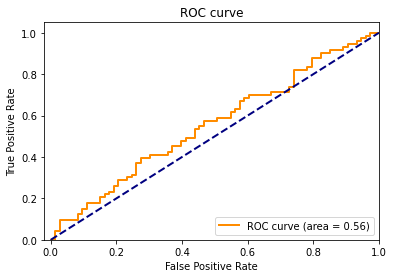

In [8]:
from xgboost import cv

ENABLE_CV_XGBOOST = True
if ENABLE_CV_XGBOOST:
    use_train = 'ds_c0001234'
    print("CV train on "+use_train)
    X = X_list[use_train]
    y = y_list[use_train]
    xgb_cv = run_xgb_cv(p=params, k=5, X=X, y=y)
    print(xgb_cv)

    # use_train = 'ds_f0001234'
    # print("CV train on "+use_train)
    # X = X_list[use_train]
    # y = y_list[use_train]
    # xgb_cv = run_xgb_cv(p=params, k=5, X=X, y=y)
    # print(xgb_cv)

    # train c model and test f
    print("========= train with {}  =========".format('ds_c0001234'))
    use_train = 'ds_c0001234'
    X = X_list[use_train]
    y = y_list[use_train]
    xgb_train = xgb.DMatrix(X.values, y.values)

    num_round = 300
    watchlist = [(xgb_train, 'train')]
    start = time.time()
    model = xgb.train(params, xgb_train, num_round, watchlist)
    end = time.time()
    print("Time to train: {} sec".format(end-start))

    # xgb_test = xgb.DMatrix(X_list['ds_f0001234'].values)
    # y_pred = model.predict(xgb_test)
    # show_roc_curve(y_test = y_list['ds_f0001234'], y_pred = y_pred)

    # # train f model and test c
    # print("========= train with {} and test on {} =========".format('ds_f0001234', 'ds_c0001234'))
    # use_train = 'ds_f0001234'
    # X = X_list[use_train]
    # y = y_list[use_train]
    # xgb_train = xgb.DMatrix(X.values, y.values)

    # num_round = 300
    # watchlist = [(xgb_train, 'train')]
    # start = time.time()
    # model = xgb.train(params, xgb_train, num_round, watchlist)
    # end = time.time()
    # print("Time to train: {} sec".format(end-start))

    # xgb_test = xgb.DMatrix(X_list['ds_c0001234'].values)
    # y_pred = model.predict(xgb_test)
    # show_roc_curve(y_test = y_list['ds_c0001234'], y_pred = y_pred)

    # use c model to test ds_mc_cancer
    print("========= train with {} and test on {} =========".format('ds_c0001234', 'ds_mc_cancer'))
    xgb_test = xgb.DMatrix(X_list['ds_mc_cancer'].values)
    y_pred = model.predict(xgb_test)
    show_roc_curve(y_test = y_list['ds_mc_cancer'], y_pred = y_pred)